#I- Introduction
Il existe plusieurs types de modèles qui pourraient être utilisés pour la classification de texte. Quelques exemples sont :


*   **1D- Conv Net** 

*   **Modèles basés sur RNN (LSTM, GRU)** 

* **Modèles basés sur des transformers (BERT, GPT2)** 

####nous avons testé les 3 types de modèles et les CNN et Bert ont montré des très bonne performance
####Dans ce projet nous allons essayer de combiner les deux pour avoir un model plus puissant qui tire parti des atouts de chaque type pour donner des meilleurs résultats.


### 1. Importing libraries and modules

In [1]:
!pip install tensorflow==2.3.0
!pip install tensorflow-gpu==2.3.0
!pip install keras==2.4.3
!pip cudatoolkit==11.0.221

     |████████████████████████████████| 320.4MB 50kB/s 
     |████████████████████████████████| 460kB 43.7MB/s 
     |████████████████████████████████| 20.1MB 66.6MB/s 
     |████████████████████████████████| 2.9MB 37.3MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Successfully uninstalled gast-0.4.0
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Found existing installation: tensorflow

     |████████████████████████████████| 320.4MB 50kB/s 
ERROR: unknown command "cudatoolkit==11.0.221"


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
from numpy import array
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers.core import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling1D
#from tensorflow.keras.layers.embeddings import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.utils import shuffle
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score

In [4]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

###2. Loading Data

####**Importing files from Google Drive in Colab**
notre dataset est stockée dans Google Drive donc nous avons besoin de 
lier notre compte Google Drive avec notre notebook.
1. La première étape consiste à monter notre Google Drive en exécutant le code en dessous.
2.  nous obtenons le code d'autorisation en nous connectant à notre compte Google.
3.   nous collons le code d'autorisation et nous appuyons sur Entrée.

In [5]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [6]:
df2 = pd.read_csv(r'/gdrive/My Drive/maillog.csv')
df3 = pd.read_csv(r'/gdrive/My Drive/messages.csv')

###3. Data Preprocessing

In [7]:
#concatinate
df=pd.concat([df2,df3])
# Shuffle the data
df = shuffle(df).reset_index(drop=True)
df.sample(10)

,Unnamed: 0,log,label
7642,1813,Jun 23 22:48:39 combo sendmail[25785]: j5K4Vht...,0
948,4017,Jul 14 21:51:29 combo sendmail[12315]: j6F1p98...,0
15877,1504,Jun 30 04:03:43 combo logrotate: ALERT exited ...,1
15709,2016,Jun 26 06:34:51 combo sendmail[4901]: j5Q4McUb...,0
7183,1256,Jun 22 13:16:30 combo ftpd[17874]: connection ...,0
6281,3028,Jul 4 14:34:06 combo sendmail[2795]: j64AhIfS...,0
12172,667,Jun 17 21:39:10 combo sendmail[30827]: j5I1bKA...,0
11362,3365,Jul 7 18:07:59 combo sendmail[13687]: j67M7xG...,0
9156,5642,Aug 4 21:38:56 combo sendmail[468]: j751axZ80...,0
9962,6870,Aug 14 06:40:51 combo sendmail[5361]: j7DNDro6...,0


In [8]:
del df['Unnamed: 0']

In [9]:
def clean_data(log):
    log = re.sub("'", "", log)
    log = re.sub("-", "", log)
    log = re.sub("_", "", log)
    log = re.sub("(\\W)+", " ", log)
    log = log.lower()
    return log

In [10]:
df['log'] = df['log'].apply(clean_data)

In [11]:
df.shape

(16342, 2)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df['log'],df['label'], test_size=0.2,random_state=42)

### CNN Processing Part:

nous utiliserons la classe Tokenizer du module keras.preprocessing.text pour créer un dictionnaire de word-to-index . Dans le dictionnaire, chaque mot est utilisé comme clé, tandis qu'un index unique correspondant est utilisé comme valeur pour la clé.

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Nous fixons la taille maximale à 100. Les listes de taille supérieure à 100 seront tronquées à 100. Pour les listes dont la longueur est inférieure à 100, nous ajouterons 0 à la fin de la liste jusqu'à ce qu'elle atteigne la longueur maximale.

In [14]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Nous utiliserons GloVe embeddings pour créer feature matrix, j'ai essayé d'importer Glove sur mon drive
* vous pouvez la trouver sur : https://drive.google.com/file/d/17PIgUPWrXOLFbUYqTAnl1cgWqnWHgX1B/view?usp=sharing

In [15]:
from numpy import array
from numpy import asarray
from numpy import zeros

glove_path=r'/gdrive/My Drive/glove.6B.100d.txt'
embeddings_dictionary = dict()
glove_file = open(glove_path, encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

Enfin, nous allons créer une embedding matrix où chaque numéro de ligne correspondra à l'index du mot. La matrice aura 100 colonnes où chaque colonne contiendra les embeddings de mots GloVe.

In [16]:
embedding_matrix = zeros((vocab_size,100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

### Bert Processing Part:

### Bert Tokenization 

* Bert accepte un type spécifique des inputs pour y répondre nous sommes tenus de:
1. Ajouter des tokens spéciaux au début[CLS] et à la fin[SEP] de chaque log.
2. Compléter et tronquer toutes les logs à une seule longueur constante "padding".
3. Différencier explicitement les vrais tokens des tokens de remplissage avec le "attention mask" 1 vrai 0 vide.


In [17]:
import tensorflow as tf
from tensorflow.keras.layers import MaxPooling1D,Conv1D,GlobalMaxPooling1D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout, Flatten, Input,Concatenate
import tensorflow_hub as hub
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2, Total size: 421.50MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'.


In [18]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 26.9MB/s 


In [19]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
import tokenization

Importons le tokenizer à l'aide du vocab file d'origine, écrivons tous les mots en minuscules, puis tokenisons les logs.

In [20]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=100):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [21]:
X_train0, X_test0, y_train0, y_test0 = train_test_split(df['log'],df['label'], test_size=0.2,random_state=42)

In [22]:
max_len = 100
train_input = bert_encode(X_train0, tokenizer, max_len=max_len)
test_input = bert_encode(X_test0, tokenizer, max_len=max_len)

# **Fine-tunning AELOG**

In [23]:
from tensorflow import keras
model = tf.keras.models.load_model(r'/gdrive/My Drive/Aelog')

In [24]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 100)     55285500    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 99, 128)      25728       embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 98, 128)      38528       embedding[0][0]                  
_______________________________________________________________________________________

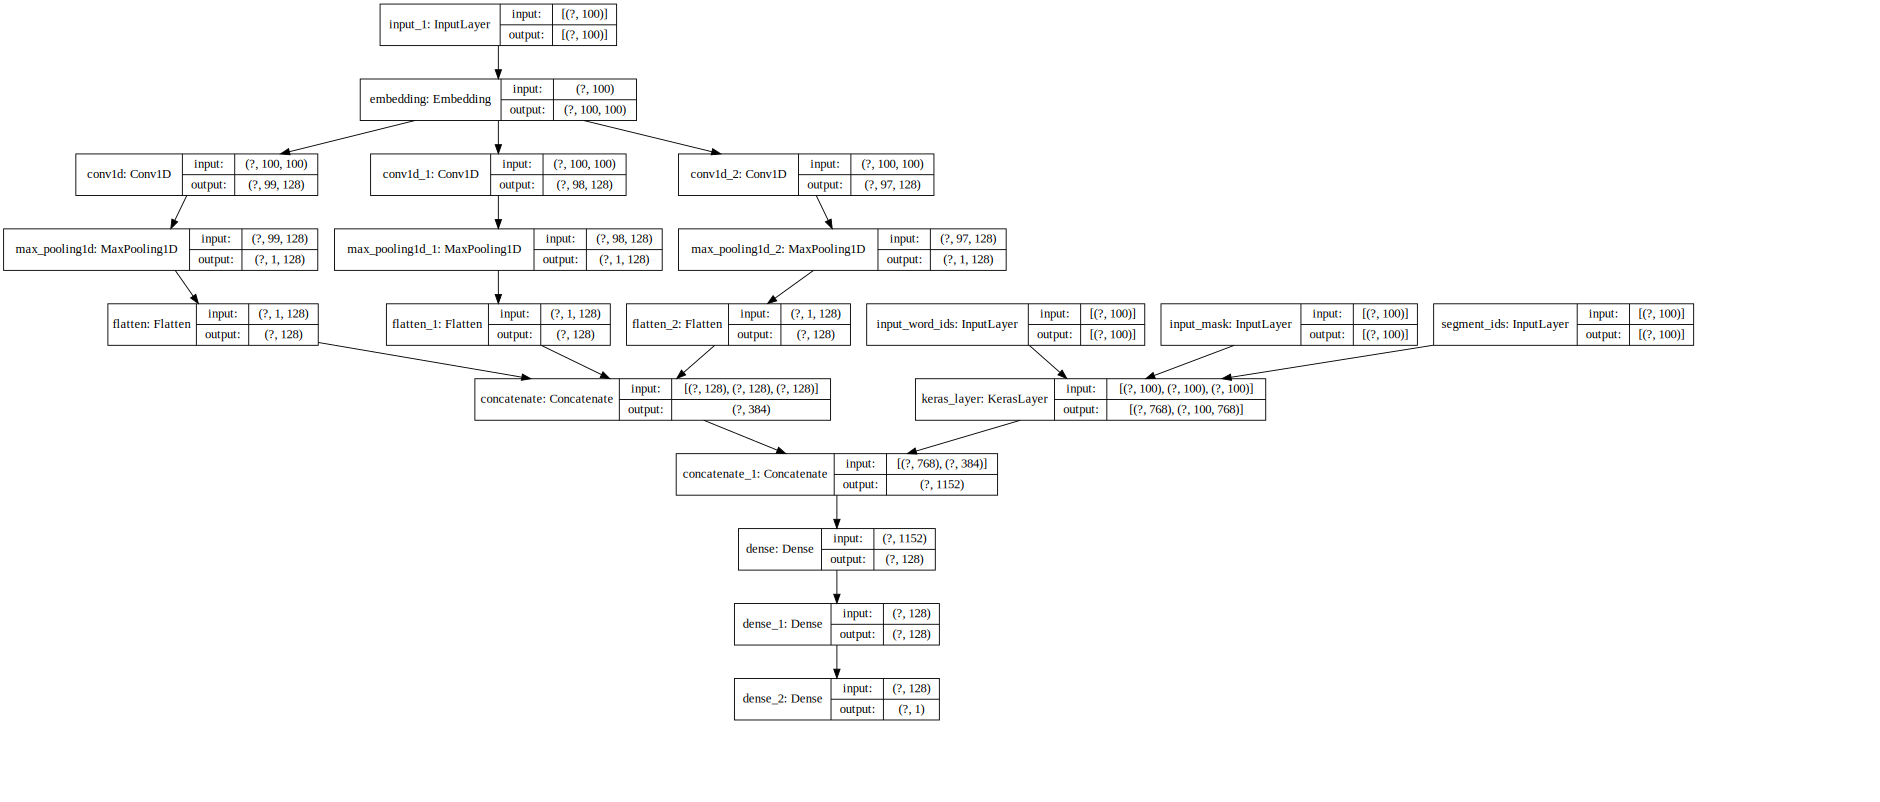

In [25]:
from IPython.display import SVG
SVG(tf.keras.utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [26]:
history = model.fit([X_train,train_input],y_train0,validation_split=0.2,epochs=2,batch_size=64)    

Epoch 1/2
164/164 [==============================] - 254s 2s/step - loss: 0.0827 - accuracy: 0.9820 - val_loss: 0.0072 - val_accuracy: 0.9992
Epoch 2/2
164/164 [==============================] - 252s 2s/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.0109 - val_accuracy: 0.9969


In [27]:
score = model.evaluate([X_test,test_input],y_test0, verbose=1) 

103/103 [==============================] - 24s 230ms/step - loss: 0.0057 - accuracy: 0.9976
